In [2]:
"""Example of the optimization process for SGOOP.  Here we find the weights of cos(phi),sin(phi),cos(psi),sin(psi)
for alanine dipeptide in vacuum from an unbiased trajectory.  We use the cos and sin of dihedral angles to avoid
inaccuracy caused by the discontinuity of angles (pi = -pi)."""
import sgoop
import scipy.optimize as opt
import numpy as np
import time
import matplotlib.pyplot as plt
import kinetics as kin

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [3]:
data1 = np.loadtxt("trajfiles/TRP_Cage/Sim1/COLVAR")
data2 = np.loadtxt("trajfiles/TRP_Cage/Sim2/COLVAR")
data3 = np.loadtxt("trajfiles/TRP_Cage/Sim3/COLVAR")
sgoop.data_array = np.concatenate([data1[:,[1,2,3,4]], data2[:,[1,2,3,4]], data3[:,[1,2,3,4]]])

In [8]:
import seaborn as sns

<Axes: ylabel='Density'>

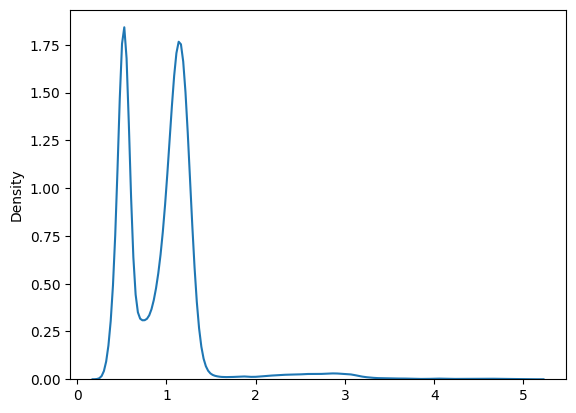

In [14]:
sns.kdeplot(data1[:,2])

In [35]:
def opti_func(rc):
    # function to be used in basinhopping. records function evaluations and returns -spectral gap
    global nfev
    nfev +=1
    return -sgoop.rc_eval(rc)

In [36]:
def biased_opti_func(rc,old_rc):
    # multidimensional equivalent of the optimization function
    global nfev
    nfev +=1
    return -sgoop.biased_eval(rc,old_rc)

In [37]:
def print_fun(x, f, accepted):
    # printing progress during optimization
    global now,last,nfev,lastf
    now=time.time()
    print(x,end=' ')
    if accepted == 1:
        print("with spectral gap %.4f accepted after %3i runs (%.3f)" % (-f, nfev-lastf, now-last))
    else:
        print("with spectral gap %.4f declined after %3i runs (%.3f)" % (-f, nfev-lastf, now-last))
    last=now
    lastf=nfev

In [38]:
def temp_print_fun(x, f, accepted):
    # printing progress while determining the temperature
    global now,last,nfev,lastf,f_array,f_i
    now=time.time()
    print(x,end=' ')
    if accepted == 1:
        print("with spectral gap %.4f accepted after %3i runs (%.3f)" % (-f, nfev-lastf, now-last))
    else:
        print("with spectral gap %.4f declined after %3i runs (%.3f)" % (-f, nfev-lastf, now-last))
    last=now
    lastf=nfev
    f_array[f_i]=-f
    f_i+=1

In [39]:
def sgoophopping(step=1,iterations=3):
    # basinhopping for 1 dimensional SGOOP
    global last,nfev,lastf,f_array,f_i
    
    f_array=np.zeros(50000)
    f_i=0

    print('---------------------------------------------------------------------------')
    print('BEGINNING',sgoop.wells,'WELL TEMPERATURE OPTIMIZATION')
    print('---------------------------------------------------------------------------')

    # Finding temperature value
    start = time.time()
    last = start
    lastf = nfev = 0
    minimizer_kwargs = {"options": {"maxiter":10}}
    ret = opt.basinhopping(opti_func,step/10*np.ones(np.shape(sgoop.data_array)[1]),niter=50,T=.01,stepsize=step, minimizer_kwargs=minimizer_kwargs, callback=temp_print_fun)
    T_new=np.mean(np.abs(f_array[0:-1]-f_array[1:]))

    replicas=[None]*iterations

    for i in range(iterations):
        print('---------------------------------------------------------------------------')
        print('BEGINNING',sgoop.wells,'WELL RC OPTIMIZATION #',i+1)
        print('---------------------------------------------------------------------------')
        start = time.time()
        last = start
        lastf = nfev = 0
        minimizer_kwargs = {"options": {"maxiter":10}}
        ret = opt.basinhopping(opti_func,step/10*np.ones(np.shape(sgoop.data_array)[1]),niter=200,T=T_new,stepsize=step, minimizer_kwargs=minimizer_kwargs, callback=print_fun)
        replicas[i]=[ret.x,-ret.fun]

    replicas=np.asarray(replicas)
    soln=replicas[:,0][np.argmax(replicas[:,1])]
    soln/=soln[np.argmax(np.abs(soln))]
    p=sgoop.md_prob(soln)
    wells_found=kin.find_wells(p)
    return wells_found,soln

In [40]:
def biashopping(old_rc,step=1,iterations=3):
    # basinhopping for  multidimensional SGOOP
    global last,nfev,lastf,f_array,f_i
    
    f_array=np.zeros(50)
    f_i=0

    print('---------------------------------------------------------------------------')
    print('BEGINNING',sgoop.wells,'WELL TEMPERATURE OPTIMIZATION')
    print('---------------------------------------------------------------------------')

    # Finding temperature value
    start = time.time()
    last = start
    lastf = nfev = 0
    minimizer_kwargs = {"options": {"maxiter":10},"args":old_rc}
    ret = opt.basinhopping(biased_opti_func,step/10*np.ones(np.shape(sgoop.data_array)[1]),niter=50,T=.01,stepsize=step, minimizer_kwargs=minimizer_kwargs, callback=temp_print_fun)
    T_new=np.mean(np.abs(f_array[0:-1]-f_array[1:]))

    replicas=[None]*iterations

    for i in range(iterations):
        print('---------------------------------------------------------------------------')
        print('BEGINNING',sgoop.wells,'WELL RC OPTIMIZATION #',i+1)
        print('---------------------------------------------------------------------------')
        start = time.time()
        last = start
        lastf = nfev = 0
        minimizer_kwargs = {"options": {"maxiter":10},"args":old_rc}
        ret = opt.basinhopping(biased_opti_func,step/10*np.ones(np.shape(sgoop.data_array)[1]),niter=200,T=T_new,stepsize=step, minimizer_kwargs=minimizer_kwargs, callback=print_fun)
        replicas[i]=[ret.x,-ret.fun]
    
    replicas=np.asarray(replicas)
    soln=replicas[:,0][np.argmax(replicas[:,1])]
    soln/=soln[np.argmax(np.abs(soln))]
    p=sgoop.md_prob(soln)
    wells_found=kin.find_wells(p)
    return wells_found,soln

---------------------------------------------------------------------------
BEGINNING 1 WELL TEMPERATURE OPTIMIZATION
---------------------------------------------------------------------------
[ 0.100  0.100  0.100  0.100] with spectral gap 0.0474 accepted after   5 runs (0.031)
[ 0.427  0.902 -0.164  0.764] with spectral gap 0.0445 accepted after   5 runs (0.038)
[-0.458  0.575 -0.716  0.039] with spectral gap 0.0564 accepted after   5 runs (0.027)
[-1.177  0.724 -0.418 -0.524] with spectral gap 0.0630 accepted after   5 runs (0.030)
[-0.761  1.259 -1.070 -0.905] with spectral gap 0.0437 declined after   5 runs (0.030)
[-1.367  1.625 -0.696 -0.638] with spectral gap 0.0533 declined after   5 runs (0.031)
[-0.321  1.429 -0.532 -0.177] with spectral gap 0.0369 declined after   5 runs (0.029)
[-1.224  1.621 -1.084 -0.296] with spectral gap 0.0517 declined after   5 runs (0.030)
[-0.705  1.265 -0.281  0.458] with spectral gap 0.0457 declined after   5 runs (0.034)
[-2.099  0.977 -0.483 -

/tmp/ipykernel_11257/875218570.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  replicas=np.asarray(replicas)


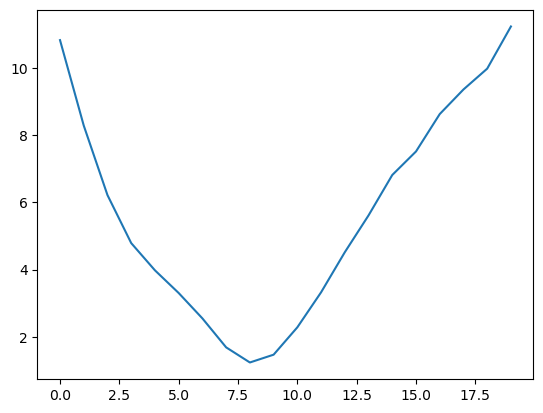

---------------------------------------------------------------------------
Optimized reaction coordinate: [ 0.033 -0.045  1.000  0.107]
This solution has 1 wells and is therefore accepted.
---------------------------------------------------------------------------
---------------------------------------------------------------------------
BEGINNING 2 WELL TEMPERATURE OPTIMIZATION
---------------------------------------------------------------------------
[ 0.100  0.100  0.100  0.100] with spectral gap 0.0408 accepted after   5 runs (0.034)
[-0.306 -0.087 -0.722  0.050] with spectral gap 0.0464 accepted after   5 runs (0.033)
[-0.769 -0.119 -1.500 -0.554] with spectral gap 0.0586 accepted after   5 runs (0.031)
[-0.294 -0.667 -0.537 -0.830] with spectral gap 0.0333 accepted after   5 runs (0.025)
[ 0.196  0.139 -0.652 -0.612] with spectral gap 0.0318 accepted after   5 runs (0.026)
[ 0.476  0.776 -0.280 -0.927] with spectral gap 0.0295 accepted after   5 runs (0.025)
[ 0.684  1.422 -0.

/tmp/ipykernel_11257/875218570.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  replicas=np.asarray(replicas)


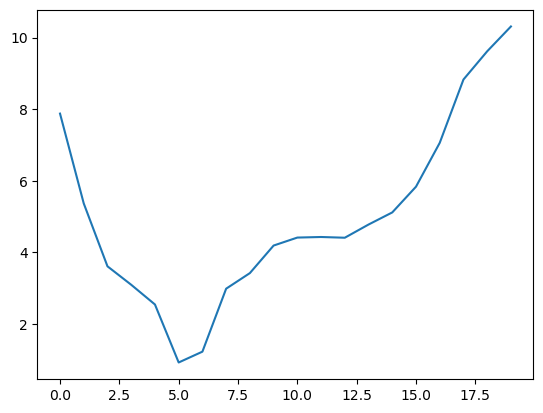

---------------------------------------------------------------------------
This solution has 1 wells and is therefore rejected.
---------------------------------------------------------------------------


In [57]:
sgoop.wells = 1
nfev=0
solutions=[]
wells_found,soln=sgoophopping(iterations=3) # calculating 2 well solution
p=sgoop.md_prob(soln)
plt.figure()
plt.plot(-np.ma.log(p))
plt.show()

while sgoop.wells == wells_found: # iteration for > 2 well solutions, continues while self consistent
    print('---------------------------------------------------------------------------')
    print('Optimized reaction coordinate:',soln)
    print('This solution has',wells_found,'wells and is therefore accepted.')
    print('---------------------------------------------------------------------------')
    solutions.append([soln,sgoop.wells])
    sgoop.wells+=1
    wells_found,soln=sgoophopping(iterations=3)
    p=sgoop.md_prob(soln)
    plt.figure()
    plt.plot(-np.ma.log(p))
    plt.show()
else:
    print('---------------------------------------------------------------------------')
    print('This solution has',wells_found,'wells and is therefore rejected.')
    print('---------------------------------------------------------------------------')

In [58]:
solutions

[[array([ 0.033, -0.045,  1.000,  0.107]), 1]]

In [59]:
rc = solutions[-1][0]
std = np.std(np.dot(sgoop.data_array,rc))
print('Optimized RC:')
print(rc)
print('Standard deviation (sigma in metad):')
print(std)

Optimized RC:
[ 0.033 -0.045  1.000  0.107]
Standard deviation (sigma in metad):
0.041754777684125575


In [60]:
hist, bins = np.histogram(np.sum(rc*sgoop.data_array, axis = 1), bins = 50)

In [61]:
import seaborn as sns

/tmp/ipykernel_11257/3085310504.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(bins[1:], -np.log(hist))


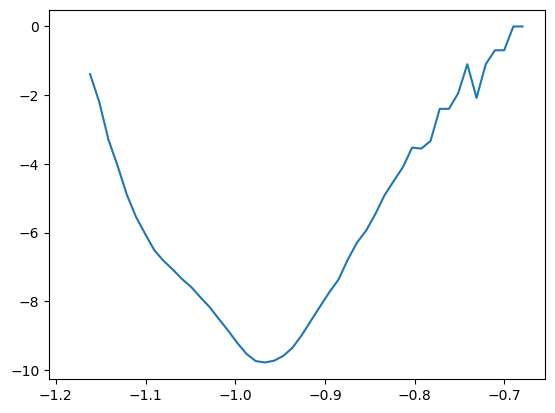

In [62]:
plt.plot(bins[1:], -np.log(hist))

In [50]:
sgoop.data_array.shape

(150000, 4)

In [34]:
occ = np.random.random(9) + np.random.random(9) * 1j
occ = occ.reshape(3,3)
ham = np.random.random(9) + np.random.random(9) * 1j
ham = ham.reshape(3,3)
for i in range(10):
    Es, phi = np.linalg.eigh(ham)
    cmat = phi@occ@(phi.T.conj())
    print(cmat)

[[ 0.34364489+0.40695138j  0.26287001+0.22006921j  0.35445093+0.1580607j ]
 [-0.04987632-0.48186608j  1.0064066 +1.35429892j  0.59328452-0.29662417j]
 [ 0.28599697+0.06432539j -0.30720823-0.19766257j  0.17910893+0.16301254j]]
[[ 0.34364489+0.40695138j  0.26287001+0.22006921j  0.35445093+0.1580607j ]
 [-0.04987632-0.48186608j  1.0064066 +1.35429892j  0.59328452-0.29662417j]
 [ 0.28599697+0.06432539j -0.30720823-0.19766257j  0.17910893+0.16301254j]]
[[ 0.34364489+0.40695138j  0.26287001+0.22006921j  0.35445093+0.1580607j ]
 [-0.04987632-0.48186608j  1.0064066 +1.35429892j  0.59328452-0.29662417j]
 [ 0.28599697+0.06432539j -0.30720823-0.19766257j  0.17910893+0.16301254j]]
[[ 0.34364489+0.40695138j  0.26287001+0.22006921j  0.35445093+0.1580607j ]
 [-0.04987632-0.48186608j  1.0064066 +1.35429892j  0.59328452-0.29662417j]
 [ 0.28599697+0.06432539j -0.30720823-0.19766257j  0.17910893+0.16301254j]]
[[ 0.34364489+0.40695138j  0.26287001+0.22006921j  0.35445093+0.1580607j ]
 [-0.04987632-0.48186

In [31]:
occ

array([[0.37839107+0.83833184j, 0.51223813+0.37428541j,
        0.2210059 +0.03306717j],
       [0.9449716 +0.5956131j , 0.77116021+0.92167497j,
        0.21559201+0.27319178j],
       [0.27362072+0.63123475j, 0.07015895+0.73272446j,
        0.28981325+0.73710481j]])